In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
posts = pd.read_csv('/kaggle/input/data-balance/AllDataFiltered.csv')
posts

,combined_text,link_flair_text
0,"for everyone, whether you're worried about cov...",psa
1,and people wonder why the virus spreads…,rant
2,r/udub mods,meme
3,thoughts on madrona? i have an emotional suppo...,discussion
4,soc 222 anyone has took or taking soc222(socio...,academics
...,...,...
10579,uw or cwru (case western) for pre med? pre-med...,advice
10580,"uw religious studies courses hi, entering uw w...",academics
10581,spanish requirements changing? i’m a prospect...,academics
10582,anyone going to seattle international film fes...,discussion


In [28]:
ModelDataFiltered=posts
flair_categories = ["admissions", "academics", "student life", "advice", "discussion", "meme", "rant", "psa", "event", "poll"]
ModelDataFiltered

,combined_text,link_flair_text
0,"for everyone, whether you're worried about cov...",psa
1,and people wonder why the virus spreads…,rant
2,r/udub mods,meme
3,thoughts on madrona? i have an emotional suppo...,discussion
4,soc 222 anyone has took or taking soc222(socio...,academics
...,...,...
10579,uw or cwru (case western) for pre med? pre-med...,advice
10580,"uw religious studies courses hi, entering uw w...",academics
10581,spanish requirements changing? i’m a prospect...,academics
10582,anyone going to seattle international film fes...,discussion


### Question:
* Can machine learning models effectively predict these flairs based on post content?
### Hypothesis:
* Posts' textual content can be used to predict flairs with reasonable accuracy, reflecting underlying patterns that distinguish different types of discussions on Reddit.
### Context and Motivation:
* Flair categorization helps in organizing content and improving user experience on Reddit. Automated flair prediction can assist moderators and enhance content discoverability.
### Definitions and Data:
* Flair: A label applied by users or moderators to categorize posts.
* Data: A dataset of Reddit posts from r/udub, including titles, bodies of text, and user-assigned flairs coming from Articshift, built upon Pushift.
### Mehtods:
* Text processing with TF-IDF vectorization to transform text data into a suitable format for machine learning.
* Clustering (K-Means) to identify inherent groupings and patterns in the data.
* Classification models including Logistic Regression and Support Vector Machines (SVM) to predict post flairs.
### Assumption:
* Assumes that the text of a post is indicative of the flair; ignores other metadata like time of posting or user engagement metrics.
### Bias:
* Potential bias in data due to self-selected flairs which may not accurately represent the content.

In [29]:
def clean_tokenize(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

ModelDataFiltered['tokens'] = ModelDataFiltered['combined_text'].apply(clean_tokenize)

In [37]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=5000)
texts_tfidf = tfidf.fit_transform(ModelDataFiltered['tokens'])

kmeans = KMeans(n_clusters=10, random_state=0)
ModelDataFiltered['cluster'] = kmeans.fit_predict(texts_tfidf)

cluster_centers = kmeans.cluster_centers_

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


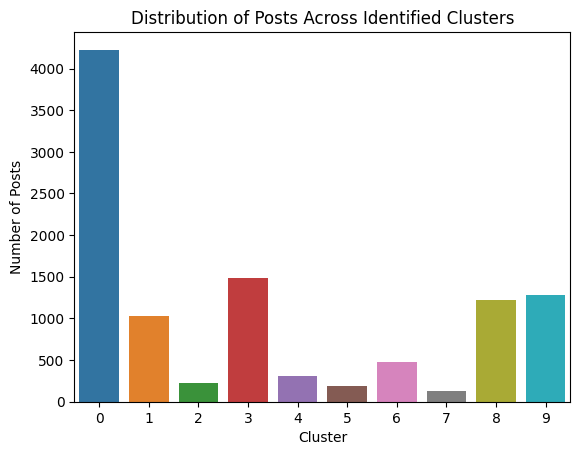

In [38]:
sns.countplot(x='cluster', data=ModelDataFiltered)
plt.title('Distribution of Posts Across Identified Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.show()

A Simple print out of how many posts are in each of the clusters

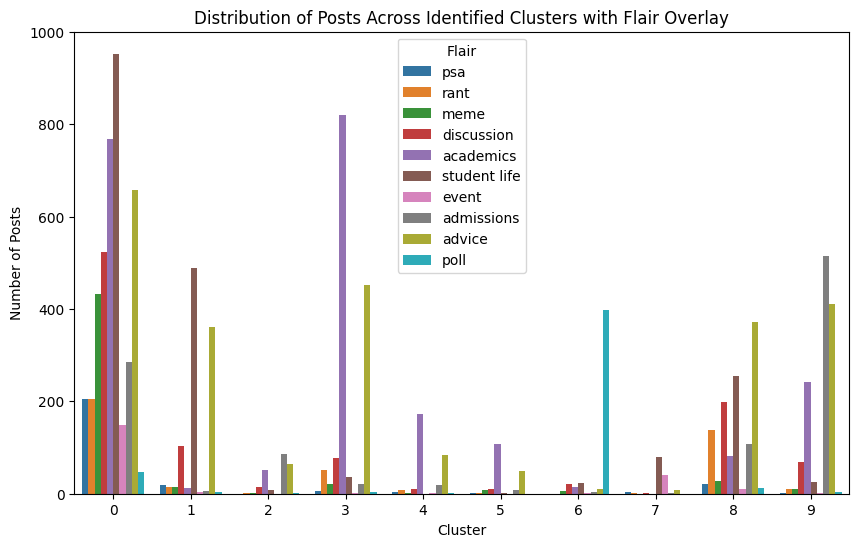

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=ModelDataFiltered, x='cluster', hue='link_flair_text')
plt.title('Distribution of Posts Across Identified Clusters with Flair Overlay')
plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.legend(title='Flair', loc='upper center')
plt.show()

Detailed view on each of the clusters, seeing how many flairs and their posts were put in these clusters. Here what we can see is that Cluster 0 and 2 was able to find a lot of "student life" and "advice" flairs. But a interesting pattern we can see here is that "advice" flair tends to be similar to a lot of other posts like "student life", "academics", and "admissions". This makes sense as advice is such a broad thing and any of the 3 flairs can technically be on advice (Maybe suggesting that ability to put multiple flairs could be nice).

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    texts_tfidf, ModelDataFiltered['link_flair_text'], test_size=0.2, random_state=42
)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

   academics       0.59      0.72      0.65       471
  admissions       0.73      0.66      0.69       215
      advice       0.44      0.49      0.46       466
  discussion       0.35      0.15      0.21       216
       event       0.50      0.05      0.08        44
        meme       0.43      0.21      0.28        97
        poll       0.82      0.88      0.85        86
         psa       0.67      0.04      0.07        53
        rant       0.59      0.20      0.30        83
student life       0.44      0.65      0.52       386

    accuracy                           0.52      2117
   macro avg       0.56      0.40      0.41      2117
weighted avg       0.52      0.52      0.50      2117



First of all, running a logistic regression model on our dataset to predict the flairs with max_iteration 1000, the best result that we end with is 0.56 accuracy. This model tends to do a great job predicting flairs for academics, admissions, student life, and poll the most.

In [34]:
accuracies = []

for flair in flair_categories:
    actual_mask = (y_test == flair)
    predicted_mask = (predictions == flair)

    correct_predictions = np.sum(actual_mask & predicted_mask)

    total_actual = np.sum(actual_mask)

    if total_actual > 0:
        accuracy = correct_predictions / total_actual
    else:
        accuracy = np.nan

    accuracies.append(accuracy)
    print(f'Accuracy for {flair}: {accuracy:.2f}')

Accuracy for admissions: 0.66
Accuracy for academics: 0.72
Accuracy for student life: 0.65
Accuracy for advice: 0.49
Accuracy for discussion: 0.15
Accuracy for meme: 0.21
Accuracy for rant: 0.20
Accuracy for psa: 0.04
Accuracy for event: 0.05
Accuracy for poll: 0.88


Using np library to calculate each of the flair's accuracy, this is what we actually get. Same kind of result as before higher accuracies finding admissions, academics, student life, and poll.

In [35]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

   academics       0.60      0.74      0.66       471
  admissions       0.72      0.64      0.68       215
      advice       0.42      0.48      0.45       466
  discussion       0.43      0.10      0.16       216
       event       1.00      0.05      0.09        44
        meme       0.60      0.19      0.28        97
        poll       0.83      0.92      0.87        86
         psa       0.00      0.00      0.00        53
        rant       0.55      0.13      0.21        83
student life       0.43      0.69      0.53       386

    accuracy                           0.52      2117
   macro avg       0.56      0.39      0.39      2117
weighted avg       0.53      0.52      0.49      2117



Using the SVM the performace compared to Logistics seems to be better in certain flairs. Overall best accuracy remains same as 0.56. However, this model worked better in identifying rant flair better and a weird 1.00 precision for event.

In [36]:
accuracies = []

for flair in flair_categories:
    actual_mask = (y_test == flair)
    predicted_mask = (svm_predictions == flair)

    correct_predictions = np.sum(actual_mask & predicted_mask)

    total_actual = np.sum(actual_mask)

    if total_actual > 0:
        accuracy = correct_predictions / total_actual
    else:
        accuracy = np.nan

    accuracies.append(accuracy)
    print(f'Accuracy for {flair}: {accuracy:.2f}')

Accuracy for admissions: 0.64
Accuracy for academics: 0.74
Accuracy for student life: 0.69
Accuracy for advice: 0.48
Accuracy for discussion: 0.10
Accuracy for meme: 0.19
Accuracy for rant: 0.13
Accuracy for psa: 0.00
Accuracy for event: 0.05
Accuracy for poll: 0.92


Slightly different accuracy results for each flairs compared to logistic regression model, some flairs were more accurate and some less, but generally still admissions, academics, student life, advice, and poll being the most accurate flairs to predict.

### Uncertainty, Limitations, and Caveats:
* Models may overfit on the training data and not generalize well to unseen posts.
* Trying out different vectorizing and tokenizing methods could change the results possibly better.
* There also might be other metadata that could be relevant to improving prediction accuracy rather than only the textual content (looking into context if we can would work better).

### New Problems and Next Steps:

* Investigate the use of more sophisticated NLP models like BERT or Longformer for better context understanding.
* Look into analyzing context of the text rather than the words and tokens to form a better group to predict flairs.